In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz
from sklearn.decomposition import PCA, FastICA
from meegkit import dss
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
folderPath = os.path.join(os.getcwd(), 'SSVEP_BCI_Dataset')

In [4]:
matFiles = [f for f in os.listdir(folderPath) if f.endswith('.mat')]
matData = scipy.io.loadmat(os.path.join(folderPath,matFiles[1]))

In [5]:
data = matData['data']

In [6]:
colName = ['Character', 'Frequency(Hz)', 'Phase（pi)']
characters = ['1','2','3','4','5','6','7','8','9','0','*','#']
FreqHz = [9.25,11.25,13.25,9.75,11.75,13.75,10.25,12.25,14.25,10.75,12.75,14.75]
PhasePi = [0,0,0,0.5,0.5,0.5,1,1,1,1.5,1.5,1.5]
simInfo = pd.DataFrame()
simInfo['Character'] = characters
simInfo['Frequency(Hz)'] = FreqHz
simInfo['Phase（pi)'] = PhasePi
simInfo

,Character,Frequency(Hz),Phase（pi)
0,1,9.25,0.0
1,2,11.25,0.0
2,3,13.25,0.0
3,4,9.75,0.5
4,5,11.75,0.5
5,6,13.75,0.5
6,7,10.25,1.0
7,8,12.25,1.0
8,9,14.25,1.0
9,0,10.75,1.5


In [7]:
channelInd = ['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']

In [8]:
timeRange = np.arange(0,2.84,1/250)
len(timeRange)

710

In [9]:
electrodeIndex = 0
blockIndex = 0
targetIndex = 3
dataMat = [timeRange]
numbChannelIndex = 8
name = ['Time']+channelInd

In [10]:
for chnInd in range(numbChannelIndex):
    dataMat.append(data[chnInd,:,electrodeIndex,blockIndex,targetIndex])

In [11]:
df = pd.DataFrame(dataMat)
df = df.transpose()
df.columns = name
df = df.set_index('Time')
df.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,88686.352294,91142.495939,87671.314935,98855.367235,115009.955466,85795.780170,79867.203824,81333.746394
0.004,88202.079427,90667.566101,87242.161467,98761.579321,114923.901255,85760.375009,79865.862719,81195.210290
0.008,88115.309961,90553.080473,87082.570021,98734.041973,114882.058792,85715.939743,79811.056245,81142.460176
0.012,88499.625832,90927.785094,87364.514909,98851.880363,114944.688376,85779.552804,79913.784856,81274.514274
0.016,88932.623800,91339.280685,87800.820935,98990.774095,115091.628736,85883.041375,80024.023654,81434.686865


In [12]:
ndf = (df-df.mean())/df.std()
ndf.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,1.202460,1.454761,1.488902,2.079818,1.946005,2.418060,0.597106,1.323079
0.004,-0.562860,-0.332462,-0.271263,1.293470,1.099954,2.043187,0.576883,0.131025
0.008,-0.879161,-0.763287,-0.925825,1.062589,0.688576,1.572702,-0.249555,-0.322871
0.012,0.521786,0.646776,0.230567,2.050583,1.304325,2.246243,1.299510,0.813407
0.016,2.100193,2.195288,2.020069,3.215111,2.748985,3.341989,2.961823,2.191636


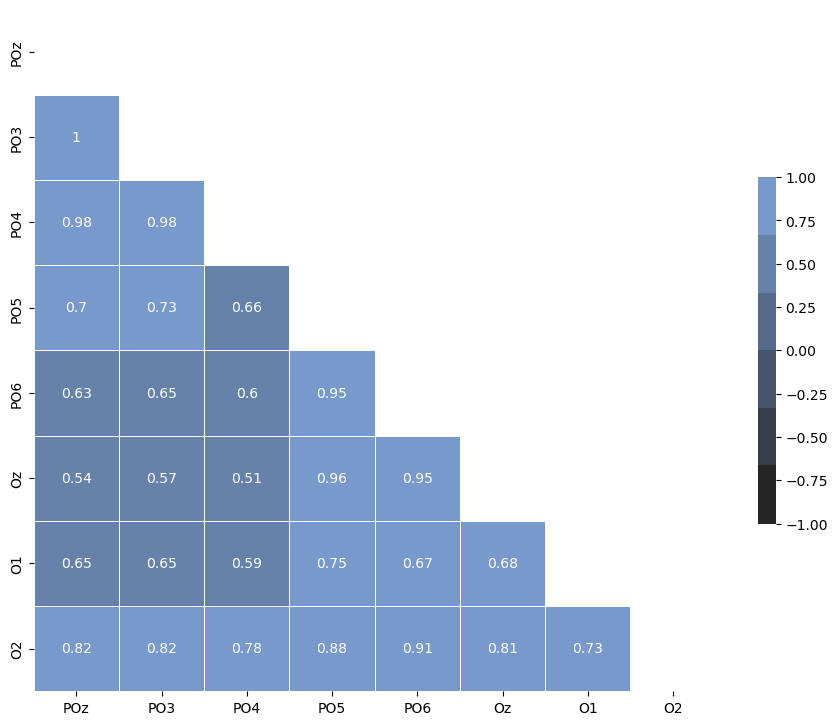

In [13]:
# Compute the correlation matrix
corr = ndf.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.dark_palette("#79C")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.show()

In [14]:
pca = PCA().fit(ndf)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

Optimal number of components: 3


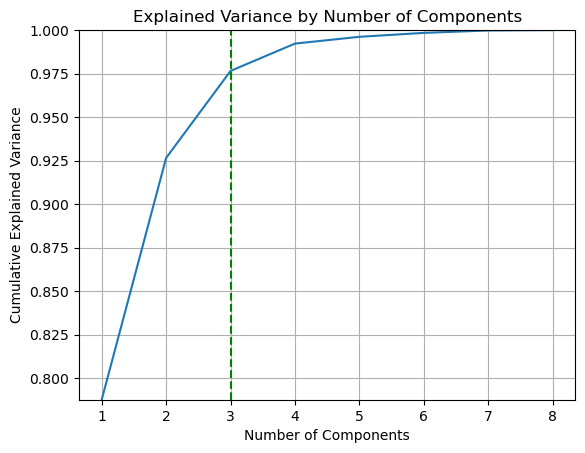

In [15]:
# Plot explained variance
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')


# Optimal number of components (e.g., 95% variance)
n_components_optimal = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of components: {n_components_optimal}")
plt.vlines(x=n_components_optimal, ymin=min(explained_variance), ymax=max(explained_variance), colors='g', ls='--')
plt.ylim(min(explained_variance),max(explained_variance))
plt.grid()
plt.show()

In [16]:
n_components = n_components_optimal
transformer = FastICA(n_components=n_components,
        random_state=0,
        whiten='unit-variance')
iComp = transformer.fit_transform(ndf.values)

In [17]:
comp = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8']
idf = pd.DataFrame(iComp)
idf.columns = comp[:n_components]
idf.head()

,comp1,comp2,comp3
0,2.221793,0.871669,-0.563082
1,1.872475,-1.085518,0.608488
2,1.862235,-1.452984,-0.133351
3,1.747870,-0.218341,1.120511
4,2.171891,1.230227,2.101537


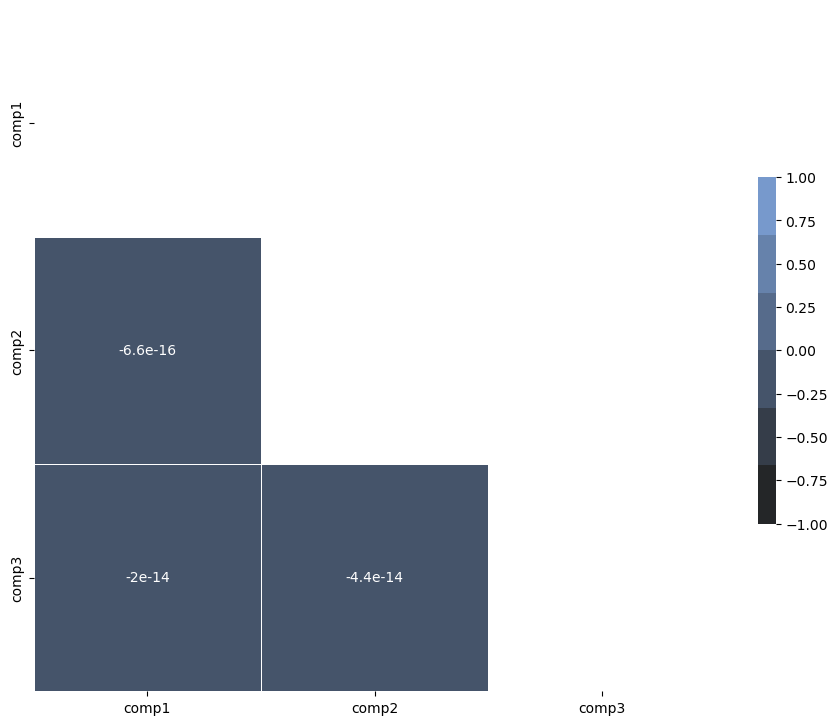

In [18]:
# Compute the correlation matrix
corr = idf.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.dark_palette("#79C")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.show()

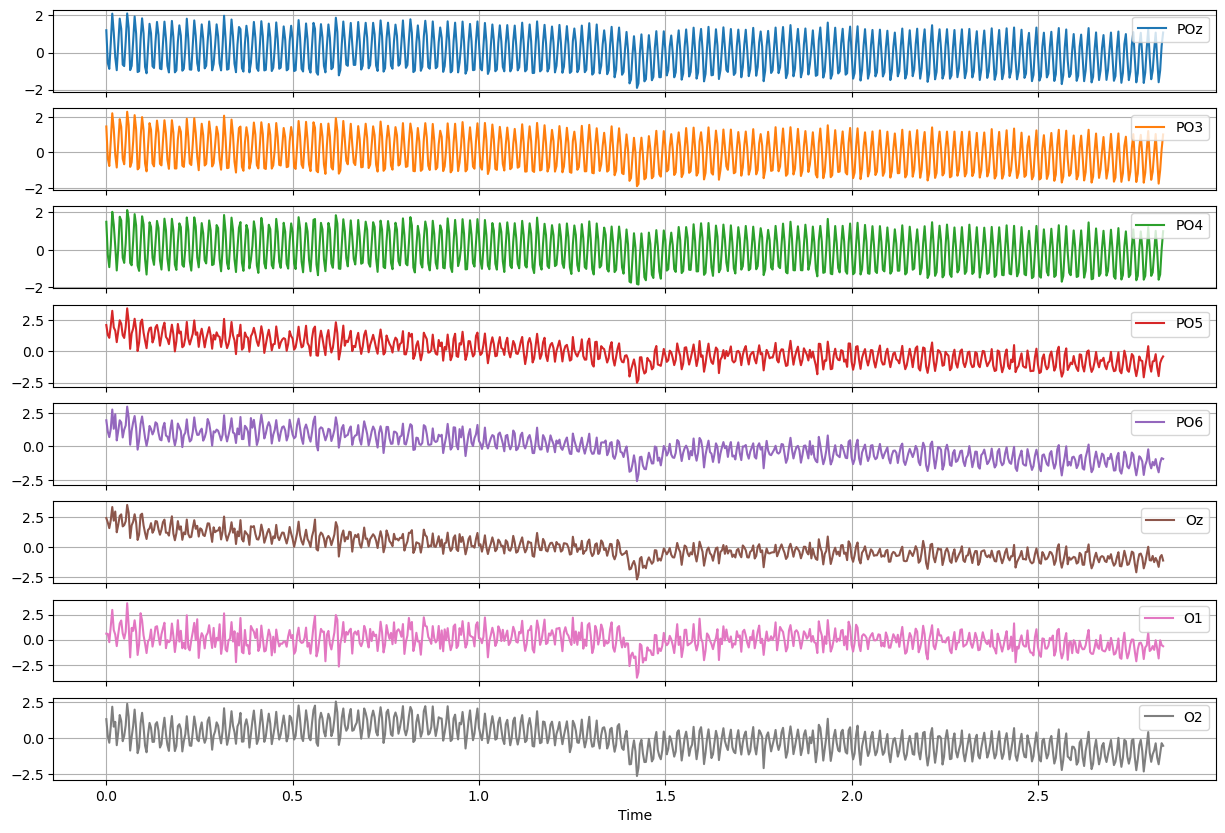

In [19]:
# plt.figure(figsize=(15,10))
ndf.plot(subplots=True,figsize=(15,10),grid=True)
plt.show()

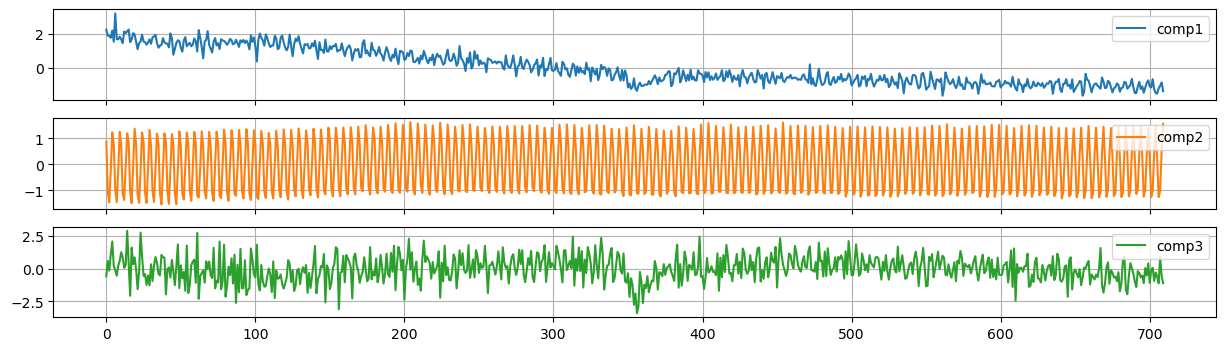

In [20]:
idf.plot(subplots=True,figsize=(15,4),grid=True)
plt.show()

In [21]:
def computeFFT(eeg_data, sampling_rate=250,absVal=True):
    # Length of the signal
    N = len(eeg_data)

    # Compute the FFT
    fft_result = np.fft.fft(eeg_data)

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, 1/sampling_rate)

    # Get the magnitude of the FFT (only the positive half of the spectrum)
    if absVal:
        fft_magnitude = np.abs(fft_result)[:N//2]
    else:
        fft_magnitude = fft_result[:N//2]
    freqs = freqs[:N//2]
    return freqs, fft_magnitude

In [22]:
# count = 1
# plt.figure(figsize=(15,10))
# for ii in range(n_components):
#     plt.subplot(8,2,count)
#     count += 1
#     Freq,Mag = computeFFT(idf[idf.columns[ii]])
#     plt.plot(Freq,np.abs(Mag),label=idf.columns[ii])
#     plt.grid()
#     plt.legend()
#     plt.ylim(0,100)
#     plt.subplot(8,2,count)
#     count += 1
#     Freq,Mag = computeFFT(ndf[ndf.columns[ii]])
#     plt.plot(Freq,np.abs(Mag),label=ndf.columns[ii])
#     plt.grid()
#     plt.legend()
#     plt.ylim(0,100)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5, wspace=0.1)
# plt.show()

In [23]:
fline = 50
sfreq = 250
out, _ = dss.dss_line(ndf.values, fline, sfreq, nkeep=1)

Reducing nfft to 710
[PCA] Explained variance of selected components : 87.33%
Power of components removed by DSS: 0.55


In [24]:
sdf = pd.DataFrame(out, columns=channelInd)
sdf.index = timeRange
sdf.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
0.000,-0.267572,0.001931,0.066356,1.173300,1.177416,1.766854,-0.451857,0.228450
0.004,-0.469236,-0.239614,-0.180061,1.353769,1.152420,2.087887,0.645957,0.203334
0.008,-0.242511,-0.133656,-0.308929,1.458643,1.026177,1.859077,0.207790,0.154692
0.012,-0.066968,0.065092,-0.338829,1.688964,0.998483,1.987251,0.880674,0.376467
0.016,0.262045,0.378574,0.241156,2.080985,1.787102,2.526953,1.649652,0.822286


In [25]:
isComp = transformer.fit_transform(sdf.values)

In [26]:
scomp = ['scomp1','scomp2','scomp3','scomp4','scomp5','scomp6','scomp7','scomp8']
isdf = pd.DataFrame(isComp)
isdf.columns = scomp[:n_components]
isdf.head()

,scomp1,scomp2,scomp3
0,0.748455,-2.702731,-2.520605
1,0.445793,-1.312148,-3.409634
2,0.470334,-1.908327,-3.204077
3,0.673563,-0.758461,-2.966982
4,1.622516,0.321668,-2.367559


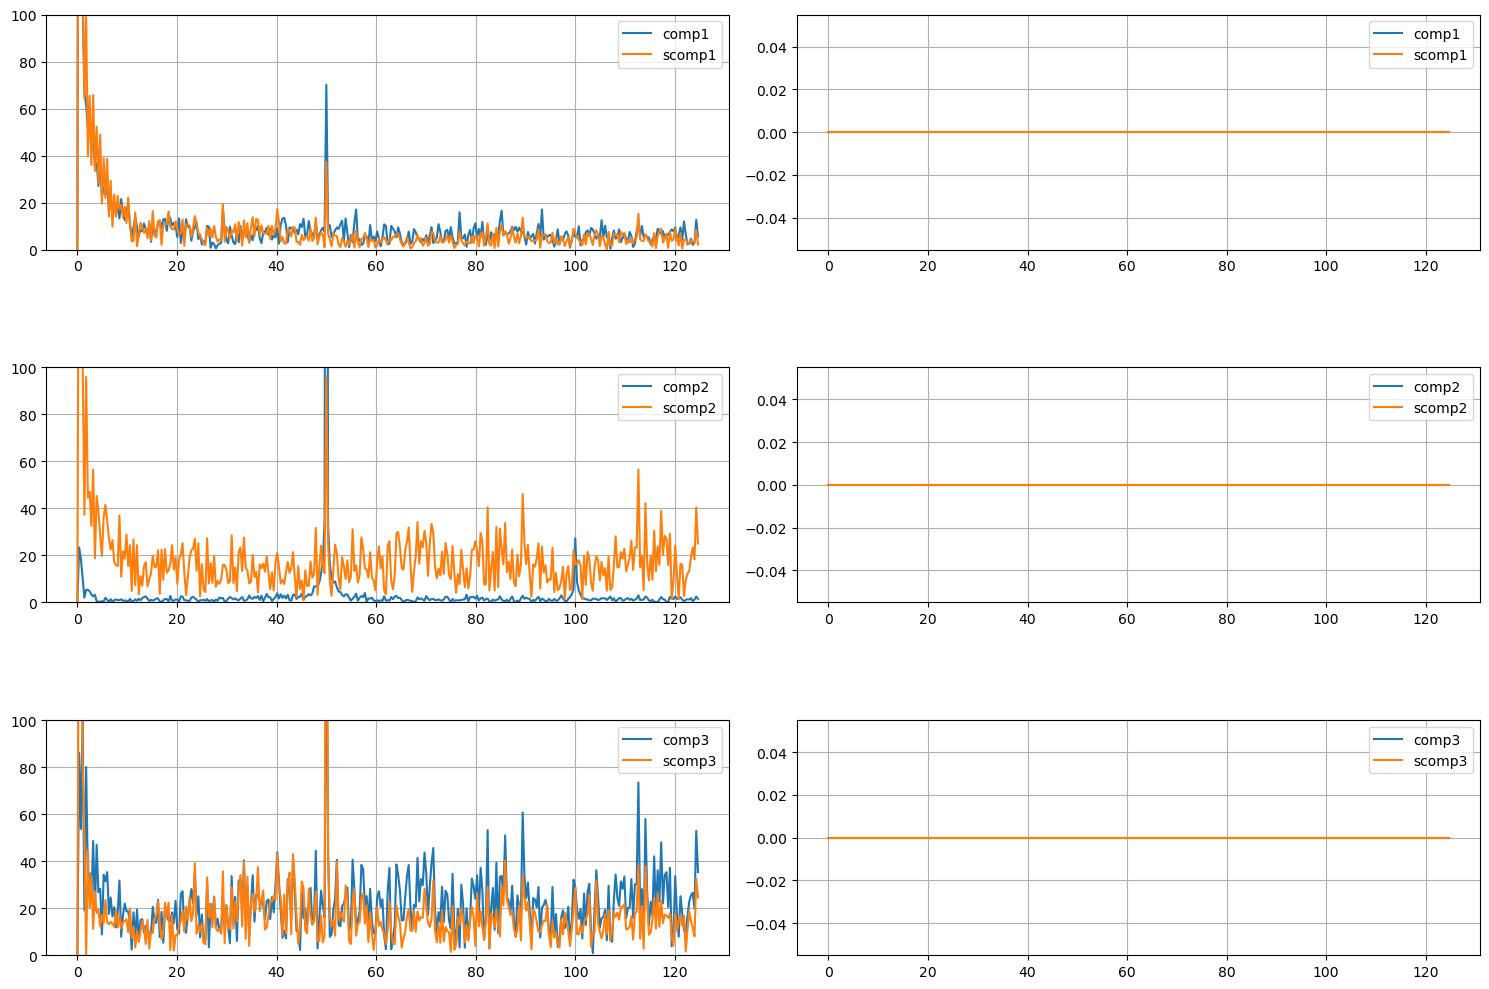

In [27]:
count = 1
plt.figure(figsize=(15,10))
for ii in range(n_components):
    plt.subplot(n_components,2,count)
    count += 1
    Freq,Mag = computeFFT(idf[idf.columns[ii]])
    Freqs,Mags = computeFFT(isdf[isdf.columns[ii]])
    plt.plot(Freq,np.abs(Mag),label=idf.columns[ii])
    plt.plot(Freqs,np.abs(Mags),label=isdf.columns[ii])
    plt.grid()
    plt.legend()
    plt.ylim(0,100)
    plt.subplot(n_components,2,count)
    count += 1
    plt.plot(Freq, np.angle(Mag),label=idf.columns[ii])
    plt.plot(Freqs, np.angle(Mags),label=isdf.columns[ii])
    plt.grid()
    plt.legend()
    # plt.ylim(0,200)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()